# Testing `dda_atl` functionality

This includes testing the workflow for dda_atl, as well as the functionality of the `dda.steps` modules.

In [1]:
# initial imports
import eeasm_icesat.dda as dda
import eeasm_icesat.atl09 as atl

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmcrameri.cm as cm

In [2]:
fname_atl = '/gws/nopw/j04/ncas_radar_vol1/eeasm/paper1/atl09/summit/processed_ATL09_20201120172445_08790901_005_01.h5'


data_high, data_low = atl.load_xarray_from_ATL09.load_xarray_from_ATL09(fname_atl, subsetVariables=atl.load_xarray_from_ATL09.SUBSET_DEFAULT, get_low_rate=True, subsetVariables_low=atl.load_xarray_from_ATL09.SUBSET_LOW_CAL)

data_atl = atl.add_coordinates.add_coordinates(data_high)
data_atl = atl.interp_low_to_high(data_low,data_atl)

del data_high, data_low
data_atl

Frozen({'profile': 3, 'time_index': 1729, 'height': 700, 'layer': 10, 'surface type': 5})


/home/users/eeasm/_scripts/ICESat2/src/eeasm_icesat/atl09/load_xarray_from_ATL09.py:137: RuntimeWarning: invalid value encountered in multiply
  padding_nan = np.empty(padding_shape) * np.nan


Frozen({'profile': 3, 'time_index': 68, 'height': 700, 'layer': 10, 'surface type': 5})
{'profile': array([1, 2, 3]), 'time_index': array([   0,    1,    2, ..., 1726, 1727, 1728])}


<xarray.Dataset>
Dimensions:         (profile: 3, time_index: 1729, height: 700, layer: 10,
                     surface type: 5)
Coordinates:
  * profile         (profile) int64 1 2 3
  * time_index      (time_index) int64 0 1 2 3 4 5 ... 1724 1725 1726 1727 1728
  * height          (height) float32 2e+04 1.997e+04 1.994e+04 ... -925.5 -955.5
  * layer           (layer) int64 0 1 2 3 4 5 6 7 8 9
  * surface type    (surface type) int64 0 1 2 3 4
    d2s             (profile, time_index) float64 221.6 221.3 ... 228.0 228.3
    height_AGL      (profile, time_index, height) float64 1.706e+04 ... -4.01...
    time            (profile, time_index) datetime64[ns] 2020-11-20T17:52:18 ...
Data variables:
    cab_prof        (profile, time_index, height) float64 nan nan ... nan nan
    cloud_flag_atm  (profile, time_index) float64 1.0 1.0 1.0 ... nan nan nan
    delta_time      (profile, time_index) float64 9.113e+07 9.113e+07 ... nan
    dem_h           (profile, time_index) float64 2.935e+03 2.935e+03 ... nan
    ds_va_bin_h     (profile, height) float64 2e+04 1.997e+04 ... -925.5 -955.5
    latitude        (profile, time_index) float64 74.54 74.54 74.54 ... nan nan
    layer_bot       (profile, time_index, layer) float64 7.439e+03 nan ... nan
    layer_top       (profile, time_index, layer) float64 1.02e+04 nan ... nan
    longitude       (profile, time_index) float64 -37.46 -37.46 ... nan nan
    surface_height  (profile, time_index) float64 2.942e+03 2.942e+03 ... nan
    cal_c           (profile, time_index) float64 9.409e+20 ... 8.893e+20

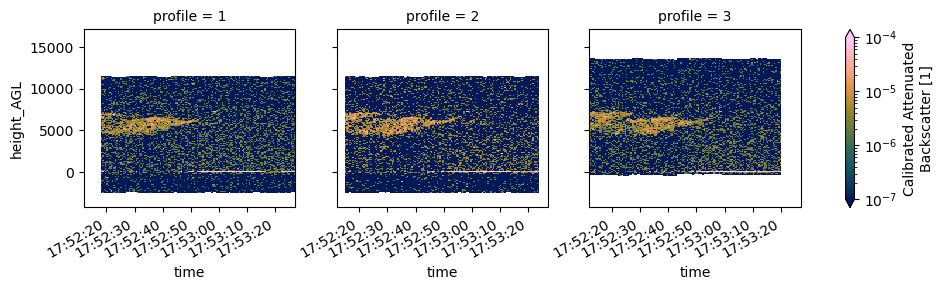

In [44]:
data_atl.cab_prof.plot(x='time',y='height_AGL', robust=True, col='profile', norm=colors.LogNorm(vmin=1e-7,vmax=1e-4,clip=True), cmap=cm.batlow)


## get data into right format for dda

This involves getting the data out of the data_atl variable in the right format.

In [4]:
# transpose the dataset into the right format
data_atl = data_atl.transpose('time_index', 'height', ...)
data_atl

<xarray.Dataset>
Dimensions:         (profile: 3, time_index: 1729, height: 700, layer: 10,
                     surface type: 5)
Coordinates:
  * profile         (profile) int64 1 2 3
  * time_index      (time_index) int64 0 1 2 3 4 5 ... 1724 1725 1726 1727 1728
  * height          (height) float32 2e+04 1.997e+04 1.994e+04 ... -925.5 -955.5
  * layer           (layer) int64 0 1 2 3 4 5 6 7 8 9
  * surface type    (surface type) int64 0 1 2 3 4
    d2s             (time_index, profile) float64 221.6 242.4 ... 248.9 228.3
    height_AGL      (time_index, height, profile) float64 1.706e+04 ... -4.01...
    time            (time_index, profile) datetime64[ns] 2020-11-20T17:52:18 ...
Data variables:
    cab_prof        (time_index, height, profile) float64 nan nan ... nan nan
    cloud_flag_atm  (time_index, profile) float64 1.0 1.0 1.0 ... 0.0 nan nan
    delta_time      (time_index, profile) float64 9.113e+07 9.113e+07 ... nan
    dem_h           (time_index, profile) float64 2.935e+03 2.904e+03 ... nan
    ds_va_bin_h     (height, profile) float64 2e+04 2e+04 ... -955.5 -955.5
    latitude        (time_index, profile) float64 74.54 74.73 74.92 ... nan nan
    layer_bot       (time_index, profile, layer) float64 7.439e+03 nan ... nan
    layer_top       (time_index, profile, layer) float64 1.02e+04 nan ... nan
    longitude       (time_index, profile) float64 -37.46 -37.46 ... nan nan
    surface_height  (time_index, profile) float64 2.942e+03 2.912e+03 ... nan
    cal_c           (time_index, profile) float64 9.409e+20 ... 8.893e+20

In [63]:
# start with profile 1
p = 1
data = data_atl.sel(profile=p).cab_prof.values
data[data < 0] = 0

heights = data_atl.height.values
dem = data_atl.sel(profile=p).dem_h.values

In [64]:
''' Template for kernal_args
kernal_args = {
    'sigma_y':,
    'dy':,
    'a_m': sigma_x/sigma_y
    'sigma_x':,
    'dx':,
    'cutoff':
    'n' -> superceeded by cutoff
    'm'
}'''
kernal_args = { # parameters given on pg134 of ATBD
    'sigma_y': 3,
    'a_m': 10,
    'cutoff': 1
}

In [65]:
kernal_args2 = {
    'sigma_y': 6,
    'a_m': 20,
    'cutoff': 1
}

In [66]:
density_args = {}

In [92]:
threshold_args = {
    'bias':2e-6,
    'sensitivity':1,
    'quantile':0.9,
    'segment_length':2
}

In [109]:
threshold_args2 = {
    'bias':1e-6,
    'sensitivity':1,
    'quantile':0.9,
    'segment_length':2
}

In [110]:
dda_args = {
    'data': data,
    'heights': heights,
    'dem': dem,
    'kernal_args': kernal_args, 'kernal_args2': kernal_args2,
    'density_args': density_args, 'density_args2': density_args,
    'threshold_args':threshold_args, 'threshold_args2':threshold_args2,
    'min_cluster_size':300,
    'remove_clusters_in_pass':False,
    'fill_clouds_with_noise':False,
    'dem_tol':3,
    'ground_width':3,
    'verbose':True
}

In [111]:
layers,density,thresholds,c_masks,ground,layer_masks = dda.dda_atl(**dda_args)

******** Starting pass 1
==== dda.steps.create_kernal.Gaussian()
==== dda.steps.calc_density()
==== dda.steps.calc_threshold()
Calculating thresholds.
===== dda.steps.calc_cloud_mask()
******** Starting pass 2
==== dda.steps.create_kernal.Gaussian()
==== dda.steps.calc_density()
==== dda.steps.calc_threshold()
Calculating thresholds.
===== dda.steps.calc_cloud_mask()
==== dda.steps.combine_masks
Removing small objects.
Small objects removed.
******** Finding ground signal
==== dda.steps.get_ground_bin()
Values flipped due to descending height order.
dem_bin.dtype=dtype('int64')
Ground identified.
Ground bins found,
ground_bin.dtype=dtype('int64')
==== dda.steps.combine_layers_from_mask()
******** Removing ground from signal
==== dda.steps.remove_ground_from_mask()
==== dda.steps.combine_layers_from_mask()
******** Calculating layer boundaries
==== dda.steps.get_layer_boundaries()


## Checking variables

In [112]:
time = data_atl.sel(profile=p).time.values

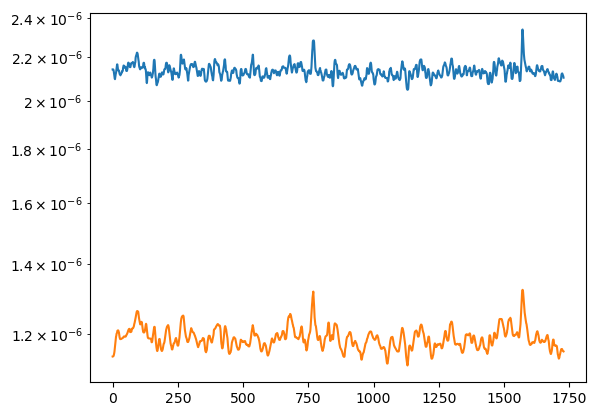

In [113]:
plt.plot(thresholds[0])
plt.plot(thresholds[1])
plt.gca().set_yscale('log')
plt.show()

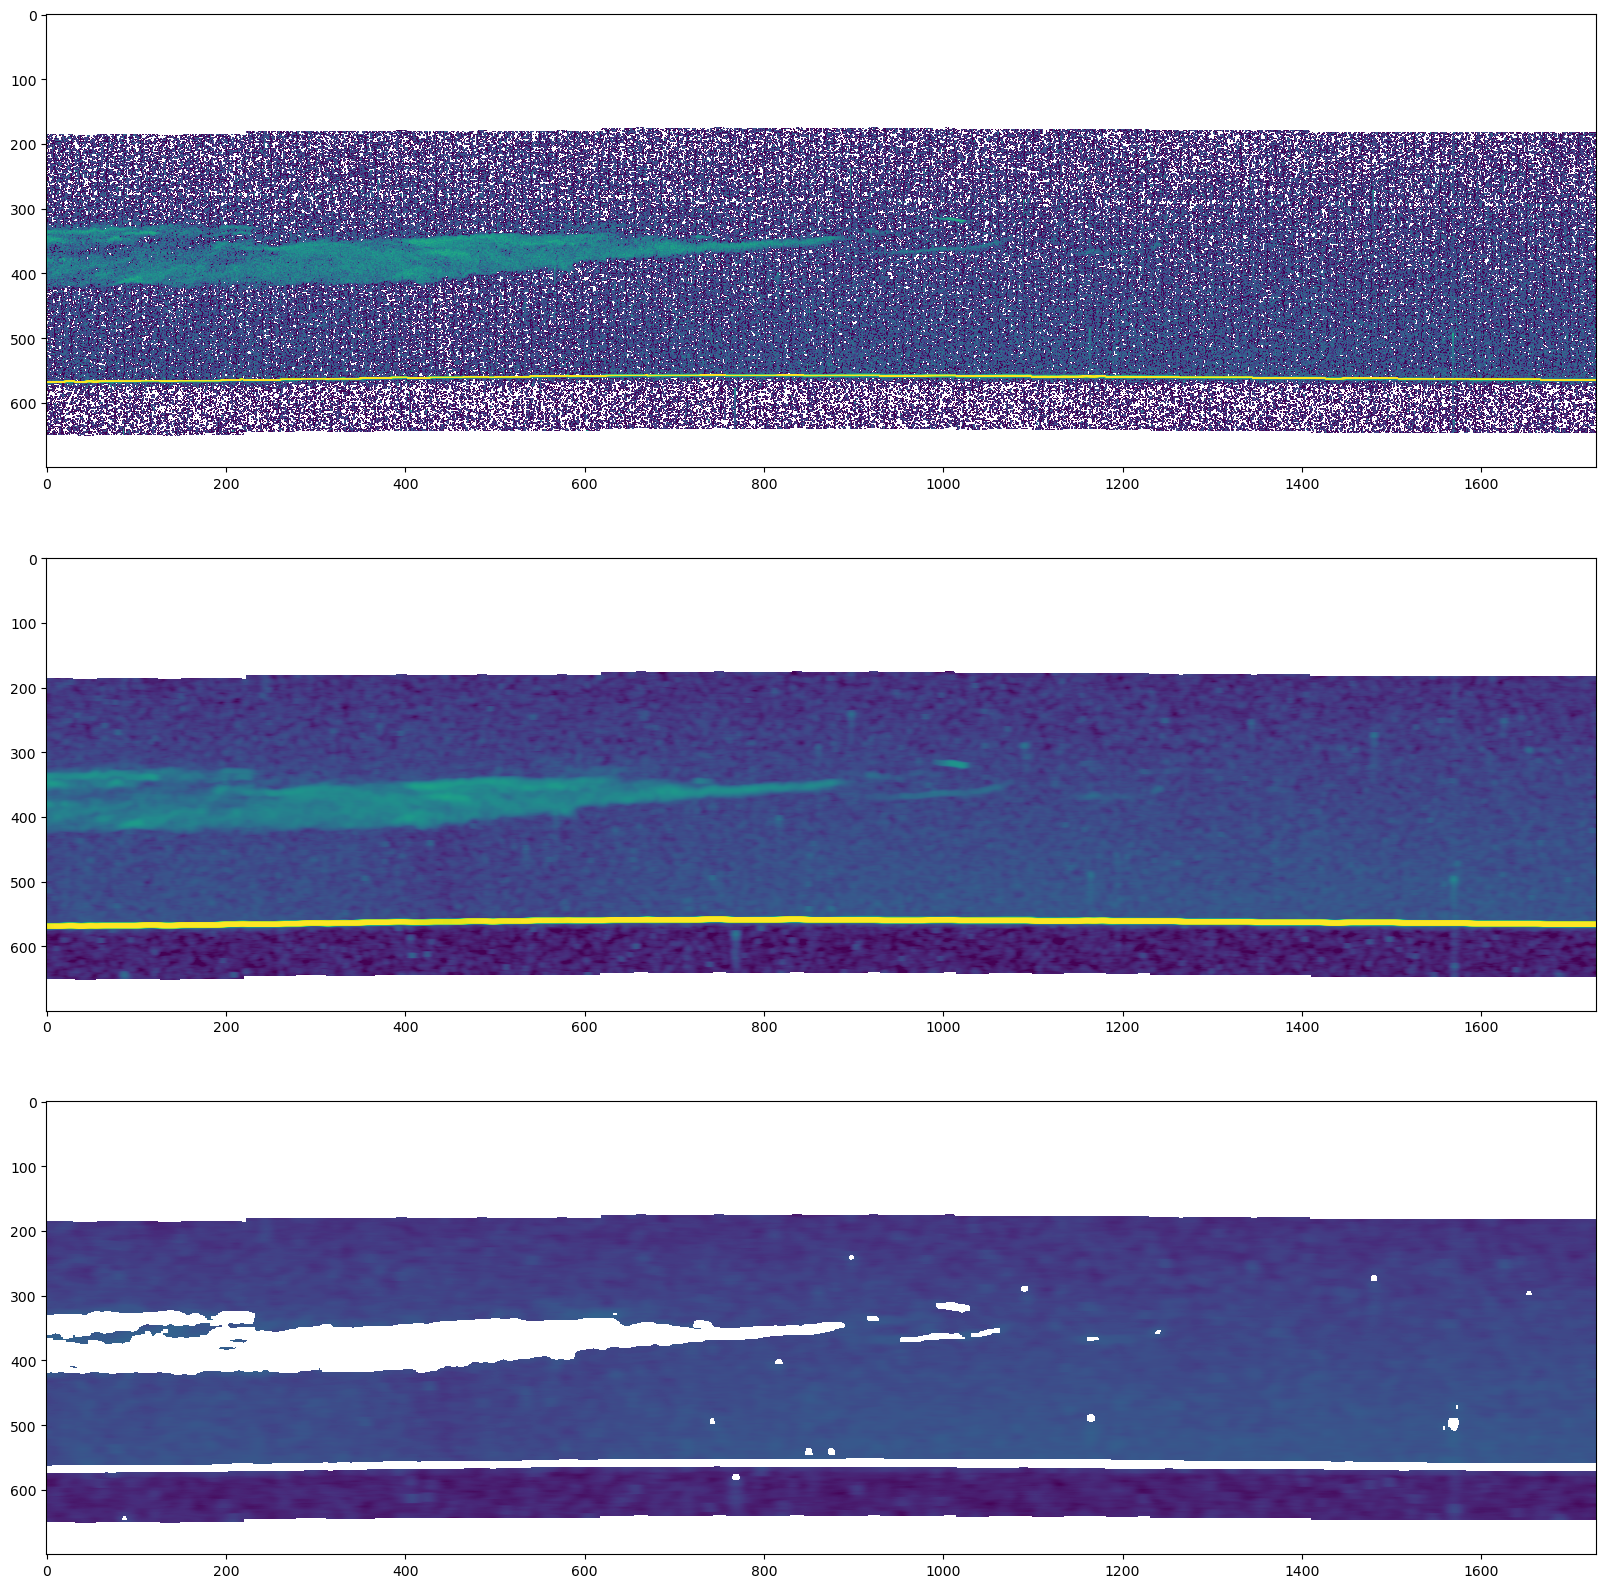

In [114]:
fig,axs = plt.subplots(3,1,figsize=(20,20))

axs[0].imshow(data.T, aspect='auto', norm=colors.LogNorm(vmin=1e-7,vmax=1e-3))
axs[1].imshow(density[0].T, aspect='auto', norm=colors.LogNorm(vmin=1e-7,vmax=1e-3))
axs[2].imshow(density[1].T, aspect='auto', norm=colors.LogNorm(vmin=1e-7,vmax=1e-3))

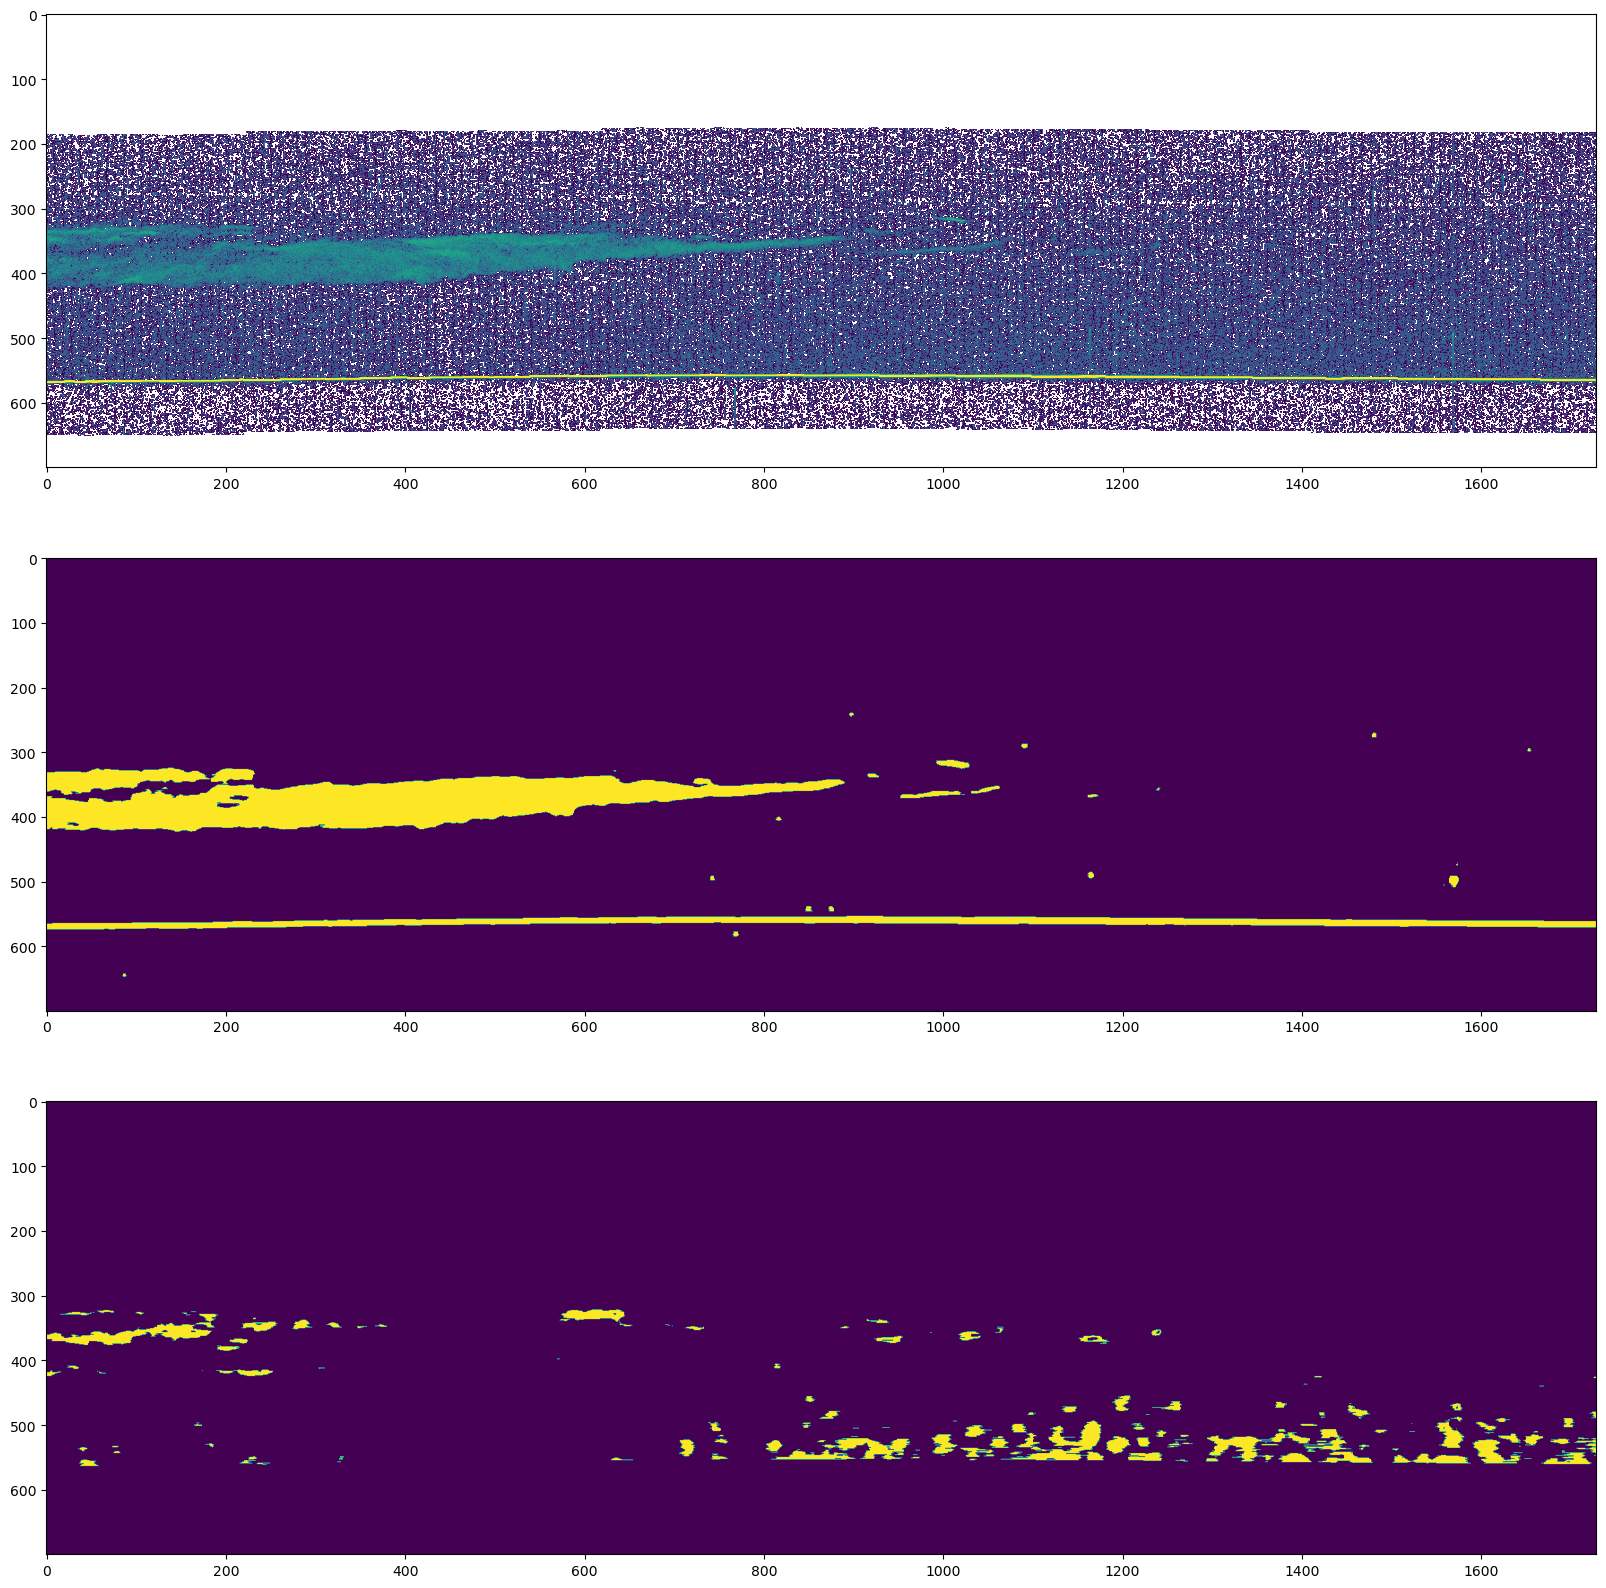

In [115]:
fig,axs = plt.subplots(3,1,figsize=(20,20))

axs[0].imshow(data.T, aspect='auto', norm=colors.LogNorm(vmin=1e-7,vmax=1e-3))
axs[1].imshow(c_masks[0].T, aspect='auto')
axs[2].imshow(c_masks[1].T, aspect='auto')

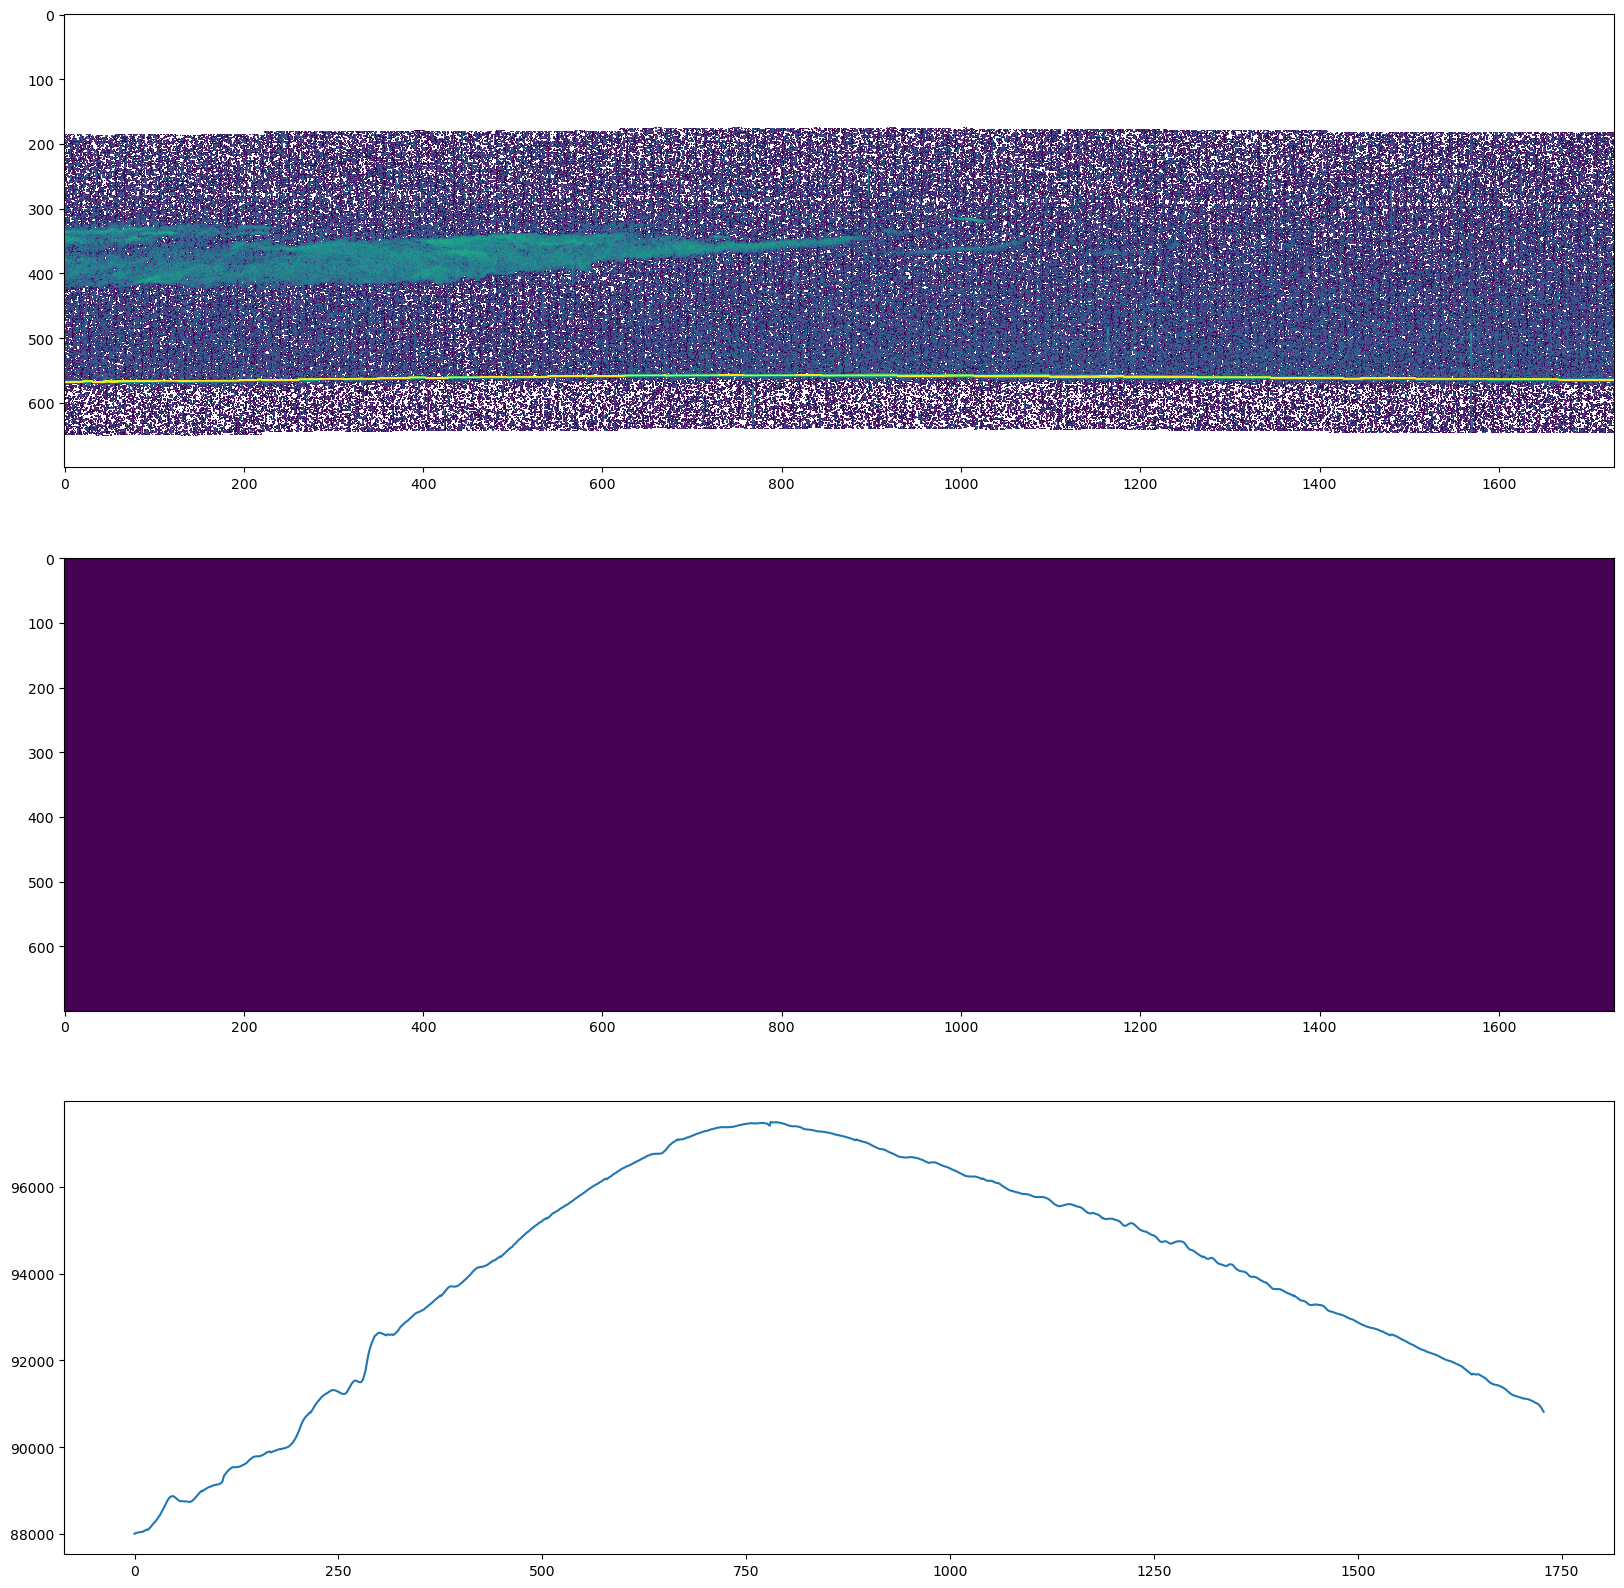

In [116]:
fig,axs = plt.subplots(3,1,figsize=(20,20))

axs[0].imshow(data.T, aspect='auto', norm=colors.LogNorm(vmin=1e-7,vmax=1e-3))
axs[1].imshow(ground[0].T, aspect='auto')
axs[2].plot(ground[1])

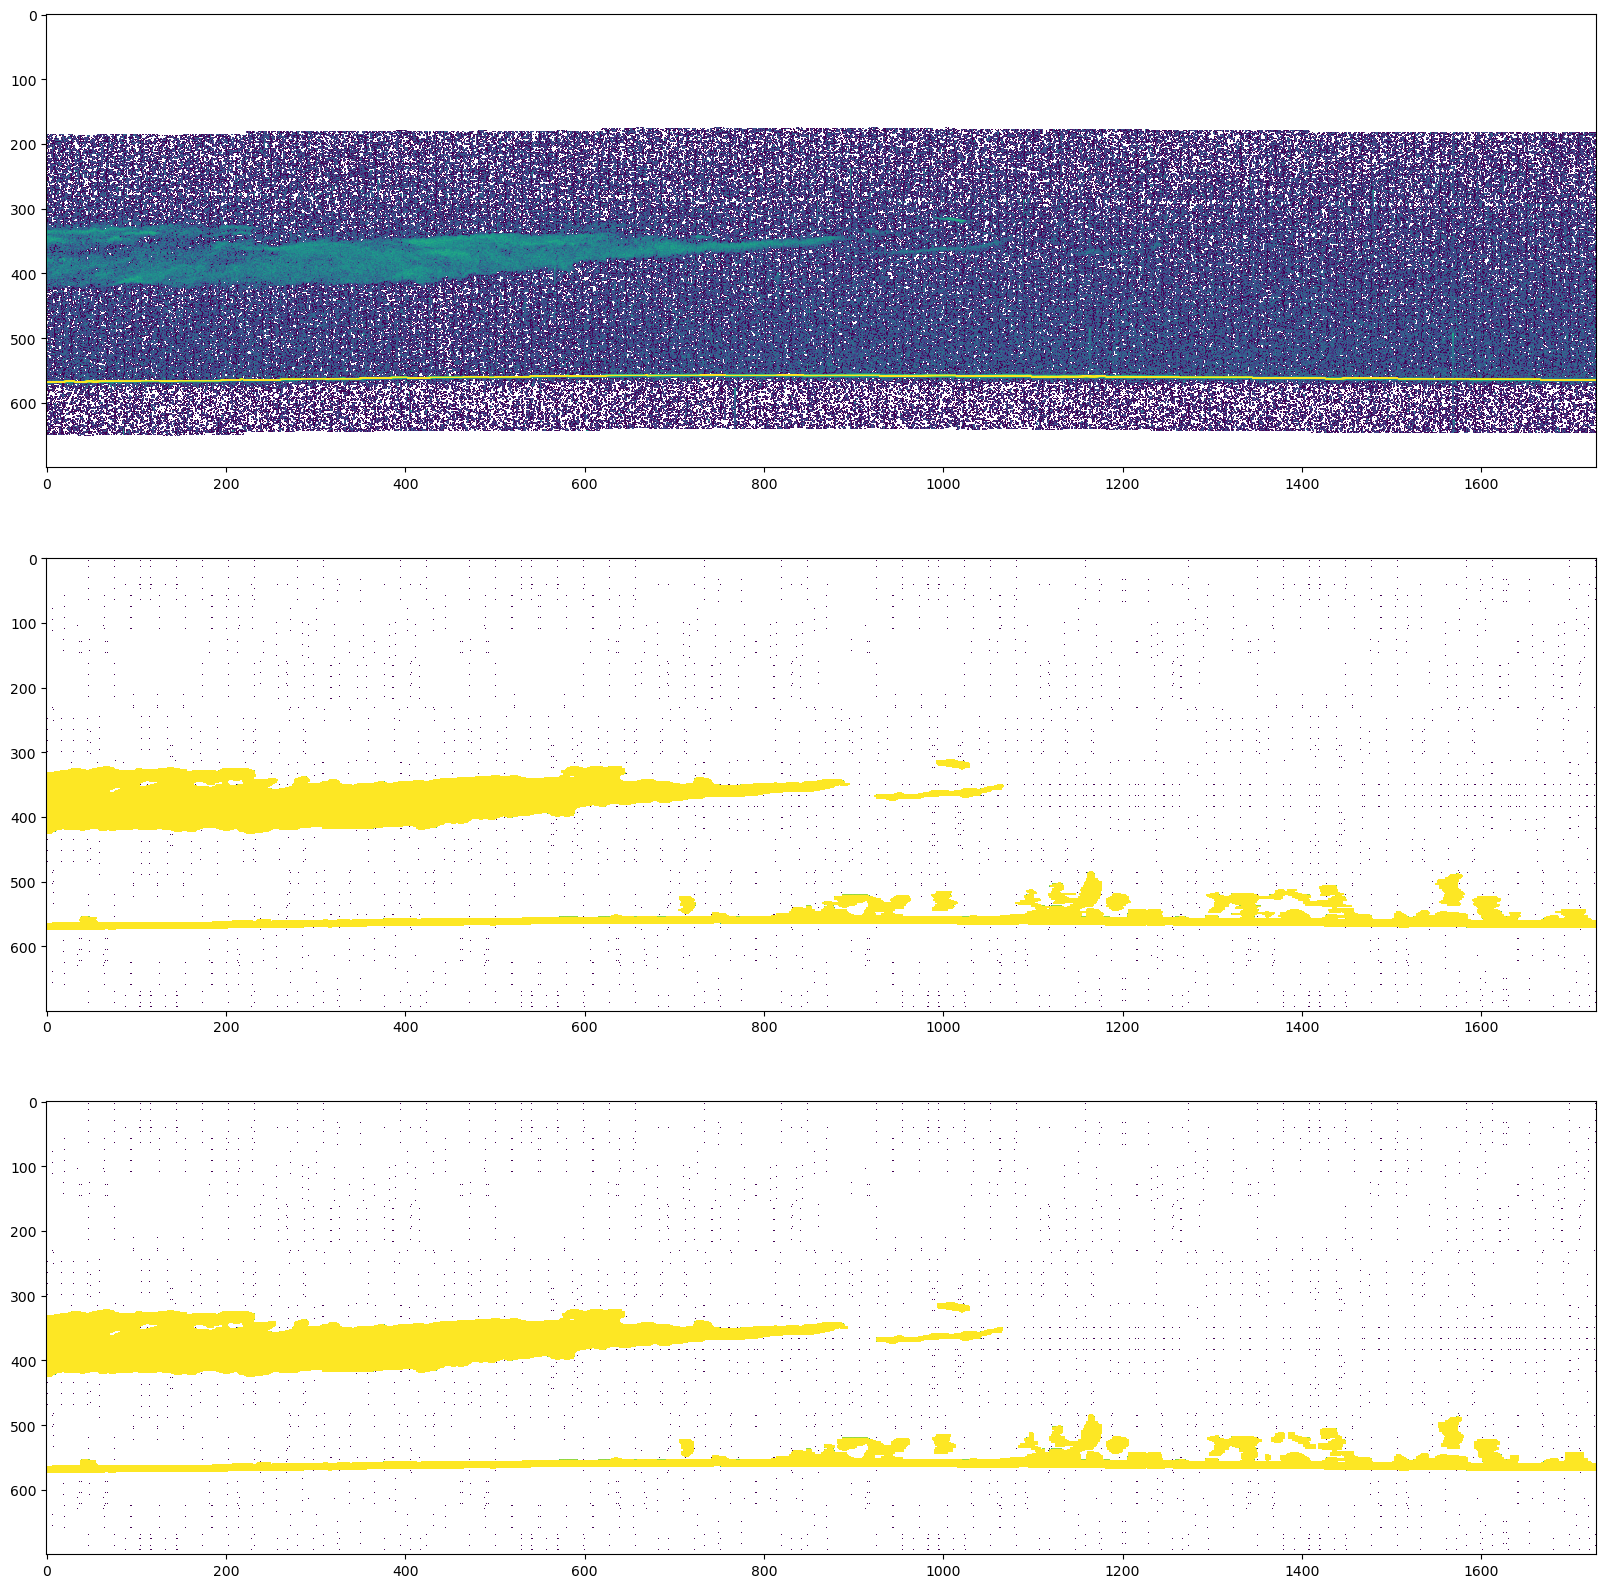

In [117]:
ig,axs = plt.subplots(3,1,figsize=(20,20))

axs[0].imshow(data.T, aspect='auto', norm=colors.LogNorm(vmin=1e-7,vmax=1e-3))
axs[1].imshow(layer_masks[0].T, aspect='auto', norm=colors.LogNorm(vmin=1e-7,vmax=1e-3))
axs[2].imshow(layer_masks[1].T, aspect='auto', norm=colors.LogNorm(vmin=1e-7,vmax=1e-3))